# Povezava do vira podatkovne zbirke: https://podatki.gov.si/dataset/surs0762112s

## BREZPOSELNOST GLEDE NA DOSEŽENO IZOBRAZBO IN SPOL, KOHEZIJSKI REGIJI


In [63]:
import warnings
warnings.simplefilter("ignore", category = FutureWarning)

# Uvozimo vse potrebne knjižnice
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression

# OPOMBE:
# Najprej smo opravili osnovno transformacijo podatkov s pomočjo programa PX-Win
# (izbor podatkov, transformacijo vrstic in stolpcev)
# Datoteko smo shranili kot .csv, ki ima podatke ločene z ';'
# V Excelu smo šumnike nadomestili s sprejemljivimi inačicami (Š - S, Č - C, Ž - Z)

# Uvozimo .csv datoteko, ki za delimiter uporablja ';'
brezposelnost = pd.read_csv("../../podatki/brezposelnost/brezposelnost.csv", sep = ";")

# V vseh vrsticah (z izjemo imen stolpcev in vrstic v tretjem stolpcu (spol 'MOSKI')) izbrišemo 'M' iz same vrednosti
# npr. namesto '3822 M' bo sedaj vrednost '3822'
brezposelnost.iloc[:, 3:] = brezposelnost.iloc[:, 3:].applymap(lambda x: x.replace('M', '') if isinstance(x, str) else x)

# V naši podatkovni zbirki vrednost 'N' predstavlja manjkajoči podatek - nadomestimo jih z NaN vrednostjo, ki jo bomo
# ustrezno nadomestili z uporabo strojnega učenja
brezposelnost.iloc[:, 3:] = brezposelnost.iloc[:, 3:].replace('N', pd.np.nan)

# Pretvorimo imena stolpcev v velike črke
brezposelnost.columns = brezposelnost.columns.str.upper()

# Zaradi kasnejših pretvorb v 'FLOAT' nadomestimo vse ',' s '.'
brezposelnost.iloc[:, 2:] = brezposelnost.iloc[:, 2:].applymap(lambda x: x.replace(',', '.') if isinstance(x, str) else x)

# Pretvorimo vrstice v velike črke
brezposelnost['KOHEZIJSKA REGIJA'] = brezposelnost['KOHEZIJSKA REGIJA'].apply(lambda x: x.upper())
brezposelnost['SPOL'] = brezposelnost['SPOL'].apply(lambda x: x.upper())

# Izberemo 5 najbljižjih sosedov
imputer = KNNImputer(n_neighbors=5)

# Nad vsakim stolpec uporabimo KNNImputer, da nadomestimo manjkajoče vrednosti z napovedjo
brezposelnost.iloc[:, 3:] = imputer.fit_transform(brezposelnost.iloc[:, 3:])

# Prvi stolpec pretvorimo v 'INTEGER'
brezposelnost.iloc[:, 0] = brezposelnost.iloc[:, 0].astype(int)
# Druga dva stolpca pretvorimo v 'STRING'
brezposelnost.iloc[:, 1:3] = brezposelnost.iloc[:, 1:3].astype(str)
# Preostale stolpce pretvorimo v 'FLOAT'
brezposelnost.iloc[:, 3:] = brezposelnost.iloc[:, 3:].astype(float)

C:\Users\janlj\AppData\Local\Temp\ipykernel_8232\1702410260.py:42: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  brezposelnost.iloc[:, 3:] = imputer.fit_transform(brezposelnost.iloc[:, 3:])
C:\Users\janlj\AppData\Local\Temp\ipykernel_8232\1702410260.py:45: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  brezposelnost.iloc[:, 0] = brezposelnost.iloc[:, 0].astype(int)


In [64]:
# Shranimo v .xlsx datoteko
# brezposelnost.to_excel('brezposelnost.xlsx', index=False)

In [65]:
# Pregled vseh stolpcev
# print(brezposelnost.columns)

# Povprečje brezposelnosti za vsako leto
po_letih = brezposelnost.groupby("LETO").mean().round(1)

# Enako, le brez prvih 4 stolpcev
po_letih_last5 = po_letih.iloc[:, -5:]

1.) Vpliv dosežene stopnje izobrazbe na stopnjo brezposelnosti (vključno s predikcijami stopenj brezposelnosti za naslednjih 5 let)
- 

Prva izmed treh stvari, ki nas je zanimala iz podatkov brezposelnosti je bila ta, kako stopnja izobrazbe ljudi vpliva na stopnjo brezposelnosti. V ta namen smo iz podatkov odstranili neuporabne stolpce ter se odločili za običajni črtni graf, ki bo prikazoval upadanje/povečanje stopnje brezposelnosti med leti 2008 ter 2022 glede na stopnjo izobrazbe.

Eden izmed problemov ki smo jih imeli je bil to, da smo imeli majhno količino podatkov/manjkajoče podatke. Za rešitev le tega smo uporabili KNN, s katerim smo "napovedali" predvideno vrednost manjkajočih polj. Ta pristop ni brez napak: podatki s tem postanejo "prirejeni", ampak se nam je ta način zdel boljši kot pa da bi te vrstice preprosto izpustili - s tem bi našo že tako omejeno zbirko podatkov še dodatno zmanjšali, s tem pa bi tudi rezultati/grafi postali slabši.

Prav tako nas je zanimala še ena stvar: kakšen bo trend brezposelnosti čez npr. 5 let? Bo brezposelnih več ali manj? Bodo ljudje z visokošolsko/višješolsko izobrazbo procentualno predstavljali večji delež brezposelnih kot pa npr. tisti s srednjo strokovno izobrazbo? V ta namen smo uporabili linearno regresijo s katero smo glede na prejšnih 5 let napovedali naslednje leto. Problem je bil sicer to, da smo imeli omejeno količino podatkov, saj se podatki le za 15 let, kar je definitivno vplivalo na kvaliteto modelov.

In [66]:
# Ustvarim seznam za vse modele za napovedovanje ter X in y seznama z ničlami
X = np.zeros((len(po_letih_last5.index) - 6, 5))
y = np.zeros(len(po_letih_last5.index) - 6)
# Seznam napovedanih vrednosti
predictions = []

# Za vsak stolpec (stopnjo izobrazbe)
for i in range(5):
    # Za vse vrstice - 6 (ker "okno" vsebuje vsaj 5 vrednosti, prav tako pa 1 odštejem zaradi vrstice ki jo napovedujem)
    for j in range(len(po_letih_last5.index) - 6):
        window = po_letih_last5.iloc[j:j+5, i]
        X[j] = window.values
        y[j] = po_letih_last5.iloc[j+6, i]
    
    # Shranim si 5 vrstic (od 10 do 15) ter jo transponiram in spremenim v seznam
    temp = po_letih_last5.iloc[10:15, i:i+1].values.T.tolist()

    # Z modelom napovem vrednosti
    model = LinearRegression().fit(X, y)
    predictions.append([])

    # Napovedane vrednosti dodam v seznam temp
    for j in range(5):
        prediction = model.predict(temp)
        del temp[0][0]
        temp[0].append(prediction[0])
        predictions[-1].append(prediction[0])

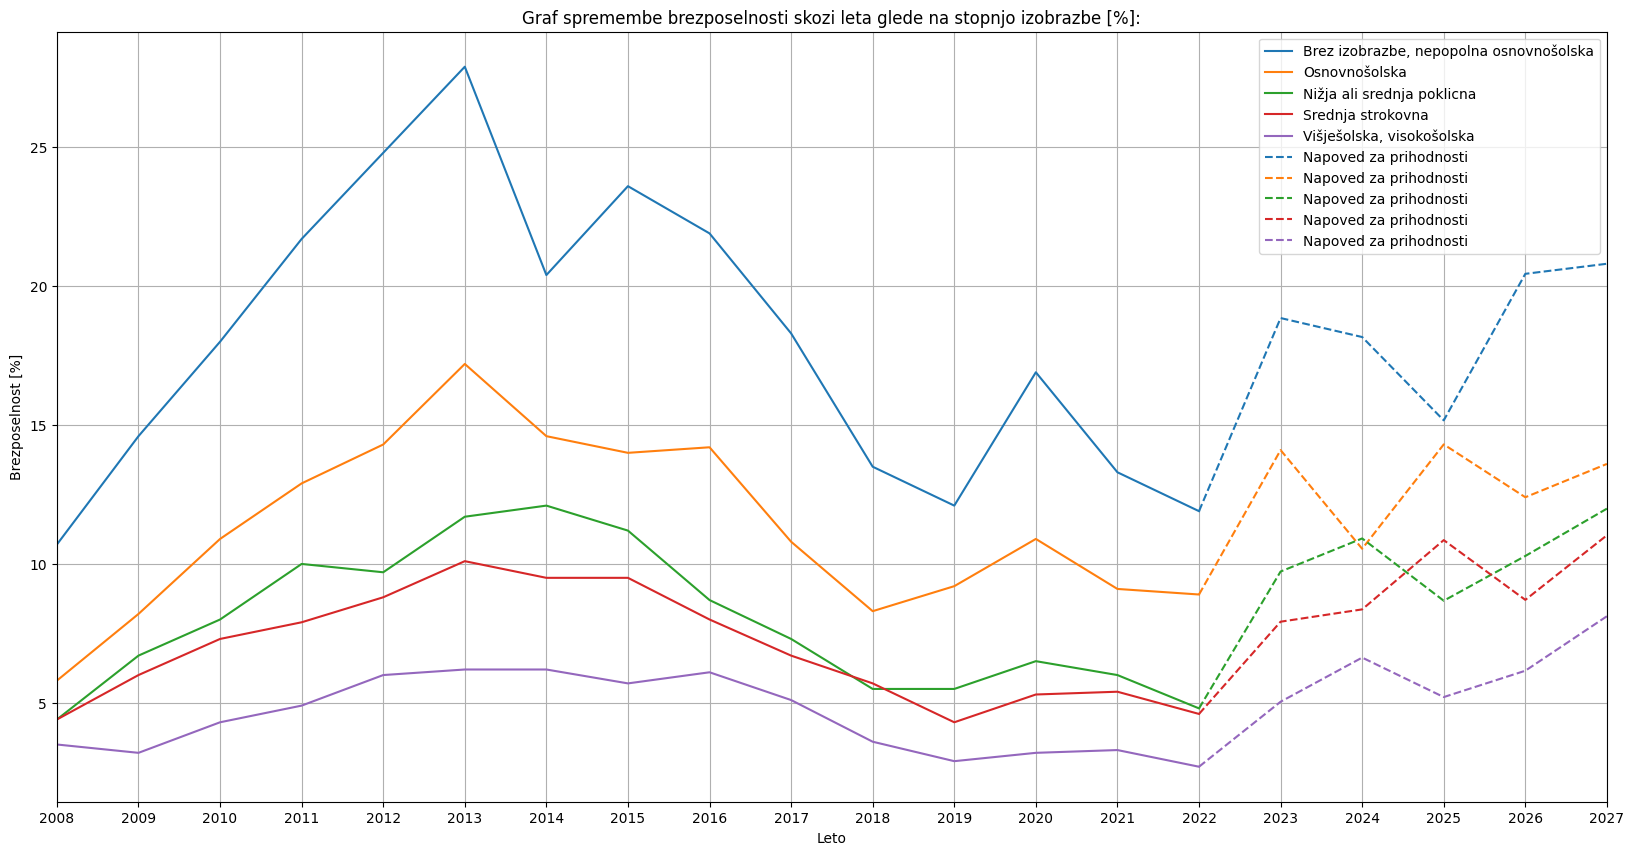

In [73]:
# Graf spremembe nezaposlenosti skozi leta glede na stopjno izobrazbe (v %)
graph1 = po_letih_last5.plot(kind="line", figsize=(20, 10))

# Naslov, imena osi ter grid
graph1.set_title("Graf spremembe brezposelnosti skozi leta glede na stopnjo izobrazbe [%]:")
graph1.set_xlabel("Leto")
graph1.set_ylabel("Brezposelnost [%]")
graph1.set_xlim(2008, 2027)

# Ureditev X osi
graph1.set_xticks(range(2008, 2023+5))

for i in range(5):
    graph1.plot(range(2022, 2023+5), [po_letih_last5.iloc[-1, i]] + predictions[i], linestyle="--", color=f"C{i}")
    graph1.legend(["Brez izobrazbe, nepopolna osnovnošolska", "Osnovnošolska", "Nižja ali srednja poklicna", "Srednja strokovna", "Višješolska, visokošolska", "Napoved za prihodnosti", "Napoved za prihodnosti", "Napoved za prihodnosti", "Napoved za prihodnosti", "Napoved za prihodnosti"])

graph1.grid()
plt.show()

Kot lahko razberemo iz zgornjega grafa največji delež brezposelnosti predstavljajo ljudje brez izobrazbe/nepopolno osnovnošolsko izobrazbo. To je dokaj logično, saj je njihov nabor delovnih mest zaradi primanjkanja osnove izobrazbe zelo ozek to pa pripelje do večje brezposelnosti.

Vse ostale stopnje izobrazbe so samoumevne, saj brezposelnost te skupine ljudi upada z višjo doseženo stopnjo izobrazbe.

Se pa na grafu pojavi par zanimivosti:
- med letoma 2017 ter 2018 je bilo več brezposelnih z srednjo strokovno šolo kot pa tistih, z nižjo ali srednjo poklicno kar je v nasprotju z zgornjo trditvijo;
- med obdobjem pandemije Covid-19 se je stopnja brezposelnosti ne glede na doseženo izobrazbo zvišala, kar je najvrjetneje posledica masovnega zapiranja firm/tovarn ter odpuščanja delavcev zaradi manjše količine naročil izdelkov/storitev;
- ko smo napovedovali brezposelnost za naslednjih 5 let se iz grafa takoj razbere da naj bi se stopnja brezposelnosti povišala ne glede na doseženo stopnji izobrazbe posameznikov;
- med letoma 2024 ter 2026 naj bi prišlo do podobne situacije kot v 2. alineji: nižje izobraženi ljudje bodo predstavljali manjši delež brezposelnih kot pa višje izobraženi v nekaterih stopnjah izobrazbe;
- brezposelnost je po letu 2008 zaradi recesije strmo naraščala vse do leta 2013, kjer je prišlo do preobrata.

2.) Vpliv spola na stopnjo brezposelnosti:
- 

Naslednje vprašanje, ki smo si ga zastavili se je glasilo: kako spol posameznika vpliva na stopnjo brezposelnosti? Tu nas brezposelnost v določenih letih ni zanimala, zato smo vrednosti let povprečili ter jih s tem gledali "skupaj".

Spet smo filtrirali podatke na tak način, da smo dobili 6 vrstic, kjer so bili navedeni: dosežena izobrazba,delež brezposelnosti moških ter delež brezposelnosti žensk.

In [68]:
# Povprečje brezposelnosti glede na spol
po_spolu = brezposelnost.groupby("SPOL").mean().round(1)

# Preuredim dataframe tako, da odstranim neuporabne vrstice ter stolpce
po_spolu = po_spolu.drop(columns=["LETO"])
po_spolu = po_spolu.drop(labels=["SPOL - SKUPAJ"])

# Transponiram podatke ter preimenujem stolpce
po_spolu_transposed = po_spolu.T.rename(columns={"MOSKI": "Moški", "ZENSKE": "Ženske"})

po_spolu_transposed

SPOL,Moški,Ženske
RAVEN DOSEZENE IZOBRAZBE - SKUPAJ DELEZ (V %),6.3,7.2
"BREZ IZOBRAZBE, NEPOPOLNA OSNOVNOSOLSKA DELEZ (V %)",18.3,18.4
OSNOVNOSOLSKA DELEZ (V %),11.7,10.9
NIZJA ALI SREDNJA POKLICNA DELEZ (V %),6.7,9.4
"SREDNJA STROKOVNA, SPLOSNA DELEZ (V %)",6.1,7.8
"VISJESOLSKA, VISOKOSOLSKA DELEZ (V %)",3.8,5.1


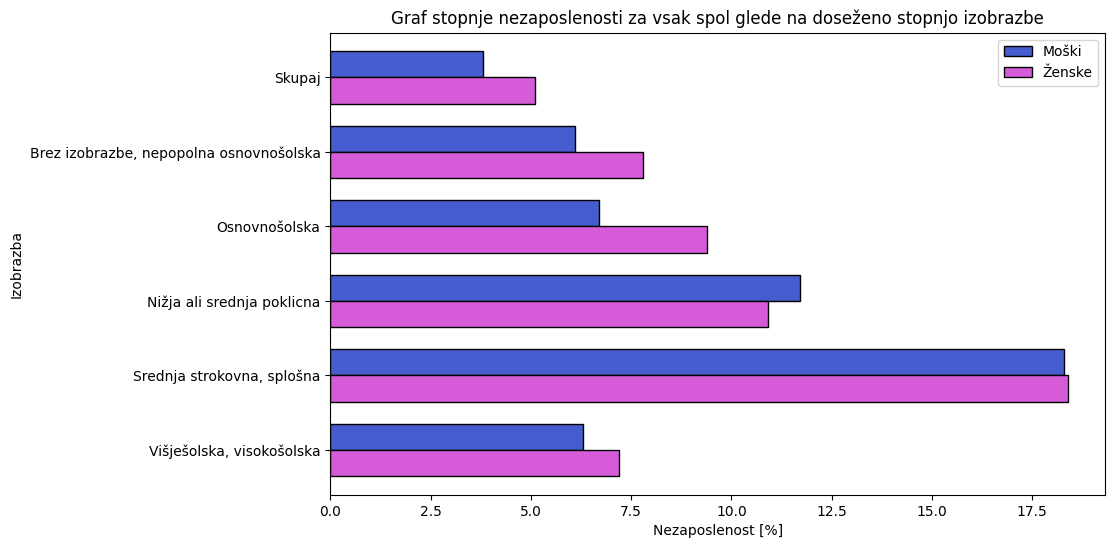

In [69]:
# Graf stopnje nezaposlenosti za vsak spol glede na doseženo stopnjo izobrazbe
graph2 = po_spolu_transposed[::-1].plot.barh(figsize=(10, 6), edgecolor="black", width=0.7, color=["#465dcf", "#d55bd9"])

# Naslov, imena osi, ureditev vrednosti Y osi, obrnjen vrstni red, grid...
graph2.set_title("Graf stopnje brezposelnosti za vsak spol glede na doseženo stopnjo izobrazbe:")
graph2.set_xlabel("Brezposelnost [%]")
graph2.set_ylabel("Izobrazba")
graph2.legend()
graph2.invert_yaxis()
graph2.set_yticklabels(["Skupaj", "Brez izobrazbe, nepopolna osnovnošolska", "Osnovnošolska", "Nižja ali srednja poklicna", "Srednja strokovna, splošna", "Višješolska, visokošolska"])
plt.show()

Iz grafa lahko zlahka razberemo prevladujočo se temo: delež brezposelnosti je večji pri ženskah kot pri moških z eno izjemo - nižja ali srednja poklicna izobrazba, kjer je brezposelnost večja pri moških.

Potencialnih razlogov, zakaj pride do tega, je lahko več:
- ženske se zaradi varstva otrok večkrat odločijo, da ostanejo doma ter se preživljajo s pomočjo socialne podpore;
- ženske so zaradi starih kulturnih ideologij o tem, da moški delajo ter služijo denar za celotno družino medtem, ko one skrbijo za otroke, odločijo, da se ne bodo zaposlile;
- zaradi napovedovanja podatkov z KNN (razloženo na začetku) pride do "nepopolne slike situacije", ker so podatki "prirejeni/spremenjeni".
- zaradi majhnega nabora izmerjenih podatkov je lahko količina žensk/moških zelo majhna, kar pomeni, da bo vsak izmed teh posamezinkov močno vplival na celotno sliko.






3.) Vpliv regije na stopnjo brezposelnosti
-   

Kot zadnje vprašanje pa smo si zastavili vprašanje, ki se glasi: kako se na področju brezposelnosti razlikujeta 2 kohezijski regiji Slovenija: Zahodna in Vzhodna Slovenija? V ta namen smo podatke glede na regijo razdelili po letih, vrednosti doseženih stopenj izobrazbe pa smo povprečili za vsako regijo za vsako leto.

In [70]:
# Odstranim nepotrebne stolpce ter izračunam povprečje glede na regijo ter leto
po_regiji = brezposelnost.groupby(["LETO", "KOHEZIJSKA REGIJA"]).mean().round(1).drop(columns={"RAVEN DOSEZENE IZOBRAZBE - SKUPAJ DELEZ (V %)"})

# Spremenim indekse (imena vrstic) v terke z regijo ter letom
mean_by_index = po_regiji.groupby([po_regiji.index, "LETO"]).mean()

# Preoblikujem dataframe v bolj pregleden format saj me stopnja izobrazbe ne zanima
combined = mean_by_index[["BREZ IZOBRAZBE, NEPOPOLNA OSNOVNOSOLSKA DELEZ (V %)", "OSNOVNOSOLSKA DELEZ (V %)", "NIZJA ALI SREDNJA POKLICNA DELEZ (V %)", "SREDNJA STROKOVNA, SPLOSNA DELEZ (V %)", "VISJESOLSKA, VISOKOSOLSKA DELEZ (V %)"]].apply(lambda row: row.mean(), axis=1)

# Preoblikujem serijo v dataframe, ponastavim indexe ter ustrezno "olepšam" dataframe za nadaljno uporabo
po_regijah = combined.to_frame().reset_index()
po_regijah = po_regijah.rename(columns={0: "NEZAPOSLENOST"})
po_regijah["level_0"] = po_regijah["level_0"].apply(lambda x: x[1])

# Preimenujem stolpec level_0 v REGIJA
po_regijah = po_regijah.rename(columns={"level_0": "REGIJA"})

po_regijah

,REGIJA,LETO,NEZAPOSLENOST
0,SLOVENIJA,2008,5.46
1,VZHODNA SLOVENIJA,2008,6.76
2,ZAHODNA SLOVENIJA,2008,5.04
3,SLOVENIJA,2009,7.52
4,VZHODNA SLOVENIJA,2009,8.52
5,ZAHODNA SLOVENIJA,2009,7.22
6,SLOVENIJA,2010,9.32
7,VZHODNA SLOVENIJA,2010,10.30
8,ZAHODNA SLOVENIJA,2010,9.52
9,SLOVENIJA,2011,11.04


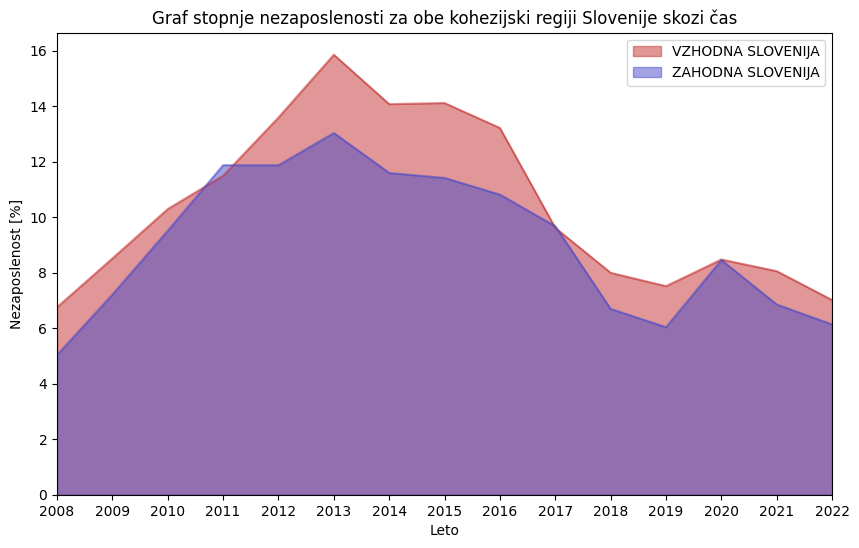

In [71]:
# Filtriram podatke glede na regijo (vzhodna/zahodna slovenija)
filtered = po_regijah[po_regijah["REGIJA"].isin(["VZHODNA SLOVENIJA", "ZAHODNA SLOVENIJA"])]

# Pivotiram filtriran dataframe da dobim stolpec za vsako regijo posebej
pivoted = filtered.pivot(index="LETO", columns="REGIJA", values="NEZAPOSLENOST")

# Izrišem graf, dodam manjkajoče letnice, imena osi ter grafa, nastavim limite X osi...
graph3 = pivoted.plot.area(stacked=False, figsize=(10, 6), color=["#c43131", "#4949c9"])
graph3.set_xlim(2008, 2022)
graph3.set_xticks(po_regijah["LETO"].unique())
graph3.set_title("Graf stopnje brezposelnosti za obe kohezijski regiji Slovenije skozi čas")
graph3.set_xlabel("Leto")
graph3.legend()
graph3.set_ylabel("Brezposelnost [%]")
plt.show()

Kot je razvidno iz grafa ter kot smo tudi pričakovali, ima Zahodna Slovenija manjšo stopnji brezposelnosti ne glede na leto (razen izjeme leta 2011), v katerem regiji primerjamo.

Tak rezultat smo pričakovali, saj Zahodna Slovenija velja za bolj "razvito" ter višje izobraženo, vsebuje tudi glavno mesto - Ljubljano. 

Kot pa je razvidno iz grafa:
- pandemija Covid-19 je v obeh kohezijskih regijah Slovenije pustila posledice - brezposelnost je takrat narasla, v letih po pandemiji pa začela upadati;
- po recesiji leta 2008 je stopnja brezposelnosti iz leta v leto strmo naraščala, situacija pa se je začela obračati šele leta 2013;

---